## lala

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ones,vstack
from numpy.linalg import lstsq
from matplotlib import _cntr as cntr
import tensorflow as tf

from data import sample_gmm_2d, graph_data,graph_surface, labels_to_one_hot
from confusion_matrix import get_confusion_matrix
from confusion_matrix import eval_AP
from confusion_matrix import eval_perf_multi

In [32]:
import tensorflow as tf
from sklearn.cross_validation import train_test_split
import math
import random

class TFDeep:
    def __init__(self, layer, param_delta=0.01, param_lambda=1e-4, activation=tf.nn.relu,
                 std=1.0, optimizer=tf.train.GradientDescentOptimizer, batch_norm = False,
                 batch_decay = 0.999, checkpoint_file="model.ckpt"):
        """Arguments:
           - D: dimensions of each datapoint
           - C: number of classes
           - param_delta: training step
        """
        self.reset()
        self.checkpoint_file = checkpoint_file
        self.sess = tf.Session()
        self.weights = []
        self.biases = []

        # definicija podataka i parametara:
        # definirati self.X, self.Yoh_, self.W, self.b
        # ...
        self.X = tf.placeholder(tf.float32, [None, layer[0]], name="input")
        self.Yoh_ = tf.placeholder(tf.float32, [None, layer[-1]], name="output")
        self.phase_train = tf.placeholder(tf.bool, name='phase_train')
        prev = layer[0]
        out = self.X

        # Makni kad prebacis u pycharm
        l2_reg = None
        for dim in layer[1:-1]:
            temp_W = tf.Variable(tf.random_normal([prev, dim], stddev=std))
            temp_b = tf.Variable(tf.random_normal([dim], stddev=std))
            out = tf.matmul(out, temp_W) + temp_b
            if batch_norm:
                out = self.batch_norm_wrapper(out,self.phase_train, decay=batch_decay)
            out = activation(out)
            prev = dim
            if l2_reg == None:
                l2_reg = tf.nn.l2_loss(temp_W) + tf.nn.l2_loss(temp_b)
            else:
                l2_reg += tf.nn.l2_loss(temp_W) + tf.nn.l2_loss(temp_b)
            self.weights.append(temp_W)
            self.biases.append(temp_b)

        temp_W = tf.Variable(tf.random_normal([prev, layer[-1]], stddev=std), name="last_layer_w")
        temp_b = tf.Variable(tf.random_normal([layer[-1]], stddev=std), name="last_layer_b")
        self.weights.append(temp_W)
        self.biases.append(temp_b)

        self.last_layer_w = temp_W

        out = tf.nn.softmax(tf.matmul(out, temp_W) + temp_b)
        if l2_reg != None:
            l2_reg += tf.nn.l2_loss(temp_W) + tf.nn.l2_loss(temp_b)
        else:
            l2_reg = tf.nn.l2_loss(temp_W) + tf.nn.l2_loss(temp_b)

        self.Y = out

        # formulacija gubitka: self.loss
        #   koristiti: tf.log, tf.reduce_sum, tf.reduce_mean
        # ...
        # Y - izlaz
        # Yoh - onehot
        self.loss = (tf.reduce_mean(-tf.reduce_sum(tf.log(self.Y) * self.Yoh_, reduction_indices=1)
                                    + param_lambda * l2_reg))

        # formulacija operacije ucenja: self.train_step
        #   koristiti: tf.train.GradientDescentOptimizer,
        #              tf.train.GradientDescentOptimizer.minimize
        # ...
        self.trainer = optimizer(param_delta)
        self.optimizer = self.trainer.minimize(self.loss)
        # instanciranje izvedbenog konteksta: self.session
        #   koristiti: tf.Session
        # ...

        pass

    def train(self, X, Yoh_, param_niter, print_every=1000, early_stop_after=50, minibatch=False):
        """Arguments:
           - X: actual datapoints [NxD]
           - Yoh_: one-hot encoded labels [NxC]
           - param_niter: number of iterations
           - early_stop_after: if False it will not early stop if it is a number the number will define patience
           - minibatch: if False it will not train in minibatches, otherwise the number will define number of batches
        """
        # incijalizacija parametara
        #   koristiti: tf.initialize_all_variables
        # ...
        X_train, X_validate, y_train, y_validate = train_test_split(X, Yoh_, test_size=0.2, stratify=Yoh_)
        self.sess.run(tf.initialize_all_variables())
        val_best = self.sess.run([self.loss], feed_dict={self.X: X_validate, self.Yoh_: y_validate, self.phase_train:False})
        cnt = 0
        num_layers = len(self.weights)
        temp_weights = [0] * num_layers
        temp_biases = [0] * num_layers

        for i in range(param_niter):

            if minibatch != False:
                self.train_mb(X_train, y_train, minibatch)
            else:
                _ = self.sess.run([self.optimizer], feed_dict={self.X: X_train, self.Yoh_: y_train, self.phase_train:True})

            loss = self.sess.run([self.loss], feed_dict={self.X: X_train, self.Yoh_: y_train, self.phase_train:False})
            if i % print_every == 0:
                print "Iteration = %d, Loss = %s" % (i, loss)
            if early_stop_after != False:
                val_loss = self.sess.run([self.loss], feed_dict={self.X: X_validate, self.Yoh_: y_validate, self.phase_train:False})
                if val_best < val_loss:
                    if cnt >= early_stop_after:
                        print "Early stopping on iteration = %d, training model restored from checkpoint with training loss = %s, validation loss = %s" % (
                        i, loss, val_loss)
                        # self.restore()
                        for i in range(num_layers):
                            self.weights[i].assign(temp_weights[i])
                            self.biases[i].assign(temp_biases[i])
                        print "Restored model validation set loss = %s" % (
                        self.sess.run([self.loss], feed_dict={self.X: X_validate, self.Yoh_: y_validate, self.phase_train:False}))
                        return
                    cnt += 1
                else:
                    cnt = 0
                    # self.save()
                    for i in range(num_layers):
                        temp_weights[i] = self.sess.run(self.weights[i])
                        temp_biases[i] = self.sess.run(self.biases[i])
                    val_best = val_loss

    def train_mb(self, X, Yoh_, num_batches):
        batch_size = int(math.ceil(len(X) / num_batches))
        data = zip(X, Yoh_)
        random.shuffle(data)
        for X_minibatch, y_minibatch in self.next_batch(data, batch_size):
            _ = self.sess.run([self.optimizer], feed_dict={self.X: X_minibatch, self.Yoh_: y_minibatch, self.phase_train:True})

    def next_batch(self, data, batch_size):
        """Yield successive n-sized chunks from l."""
        for i in xrange(0, len(data), batch_size):
            yield zip(*data[i:i + batch_size])

    def eval(self, X):
        """Arguments:
           - X: actual datapoints [NxD]
           Returns: predicted class probabilites [NxC]
        """
        #   koristiti: tf.Session.run
        return self.sess.run(self.Y, feed_dict={self.X: X, self.phase_train:False})
        pass

    def batch_norm_wrapper(self, inputs, is_training, decay = 0.999):

        scale = tf.Variable(tf.ones([inputs.get_shape()[-1]]))
        beta = tf.Variable(tf.zeros([inputs.get_shape()[-1]]))
        pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
        pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)
        
        
        
        def f_train():
            batch_mean, batch_var = tf.nn.moments(inputs,[0])
            train_mean = tf.assign(pop_mean,
                                   pop_mean * decay + batch_mean * (1 - decay))
            train_var = tf.assign(pop_var,
                                  pop_var * decay + batch_var * (1 - decay))
            with tf.control_dependencies([train_mean, train_var]):
                return tf.nn.batch_normalization(inputs,
                    batch_mean, batch_var, beta, scale, 1e-3)
        def f_test():
            return tf.nn.batch_normalization(inputs,
                pop_mean, pop_var, beta, scale, 1e-3)
        
        normed = tf.cond(self.phase_train,f_train, f_test)
        return normed
    
    def get_last_layer_weights(self):
        return self.sess.run([self.last_layer_w])

    def save(self):
        self.saver = tf.train.Saver()
        self.saver.save(self.sess, self.checkpoint_file)

    def restore(self):
        self.saver = tf.train.Saver()
        self.saver.restore(self.sess, self.checkpoint_file)

    def reset(self):
        tf.reset_default_graph()

    def __del__(self):
        self.sess.close()

Iteration = 0, Loss = [0.68806297]
Iteration = 50, Loss = [0.60954744]
Iteration = 100, Loss = [0.4959887]
Iteration = 150, Loss = [0.33002067]
Iteration = 200, Loss = [0.27799866]
Iteration = 250, Loss = [0.27512497]
Iteration = 300, Loss = [0.26460594]
Iteration = 350, Loss = [0.26817644]
Iteration = 400, Loss = [0.27043349]
Iteration = 450, Loss = [0.26089573]
Iteration = 500, Loss = [0.2633909]
Iteration = 550, Loss = [0.25839621]
Iteration = 600, Loss = [0.25477666]
Iteration = 650, Loss = [0.25582683]
Iteration = 700, Loss = [0.26245224]
Early stopping on iteration = 730, training model restored from checkpoint with training loss = [0.25846517], validation loss = [0.29612261]
Restored model validation set loss = [0.29612261]
            0     1
     0[    49    11]
     1[     5   115]
accuracy
0.911111111111
precision
[0.90740740740740744, 0.91269841269841268]
recall
[0.81666666666666665, 0.95833333333333337]
AP_c0
0.967902230903
AP_c1
0.992225121848


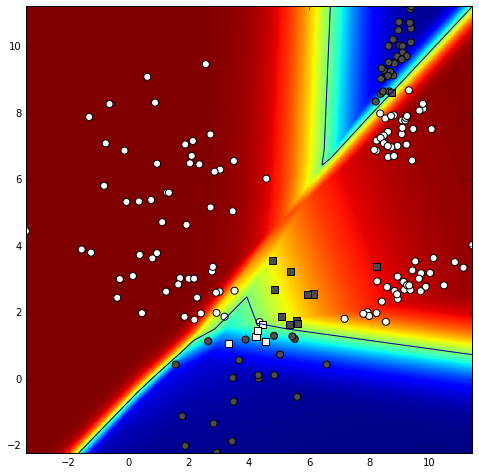

In [39]:
C=2
np.random.seed(423245)
layers = [2,10,10,2]
input_data, expected_output = sample_gmm_2d(6,C,30)

tfDeep = TFDeep(layer=layers,param_delta=0.01,param_lambda=0.01,activation=tf.nn.relu,std=0.1, batch_norm=False)
tfDeep.train(input_data,labels_to_one_hot(expected_output,C),10000,print_every=50,early_stop_after=50,minibatch=20)

def predict_c1_class_tf(X):
    def classify(X):
        return tfDeep.eval(X)[:,1]
    return classify


decfun = predict_c1_class_tf(input_data)

# evaluate the model on the train set
probs = tfDeep.eval(input_data)

# recover the predicted classes Y
my_predictions = probs[:,1] >0.5
my_predictions = my_predictions.flatten()


# graph the decision surface
bbox=(np.min(input_data, axis=0), np.max(input_data, axis=0))

#axis limits of the graph
xmin, ymin = bbox[0]
xmax, ymax = bbox[1]
plt.figure(figsize=(8,8))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

possible_labels = np.array(range(C))
mat = get_confusion_matrix(my_predictions,expected_output,possible_labels,True)
accuracy, prec, rec = eval_perf_multi(mat)
AP_c0 = eval_AP(expected_output[probs[:,0].argsort()],0)
AP_c1 = eval_AP(expected_output[probs[:,1].argsort()],1)

print "accuracy"
print accuracy
print "precision"
print prec
print "recall"
print rec
print "AP_c0"
print AP_c0
print "AP_c1"
print AP_c1

graph_surface(decfun, bbox, offset=0.5)

# graph the data points
graph_data(input_data, expected_output, my_predictions)

# show the plot
plt.show()

Iteration = 0, Loss = [0.68029439]
Iteration = 50, Loss = [0.5589667]
Iteration = 100, Loss = [0.42853153]
Iteration = 150, Loss = [0.38358715]
Iteration = 200, Loss = [0.23911142]
Iteration = 250, Loss = [0.29882988]
Iteration = 300, Loss = [0.21767637]
Iteration = 350, Loss = [0.19760755]
Early stopping on iteration = 369, training model restored from checkpoint with training loss = [0.1864215], validation loss = [0.1949148]
Restored model validation set loss = [0.1949148]
            0     1
     0[    55     5]
     1[     6   114]
accuracy
0.938888888889
precision
[0.90163934426229508, 0.95798319327731096]
recall
[0.91666666666666663, 0.94999999999999996]
AP_c0
0.976924284569
AP_c1
0.993685174226


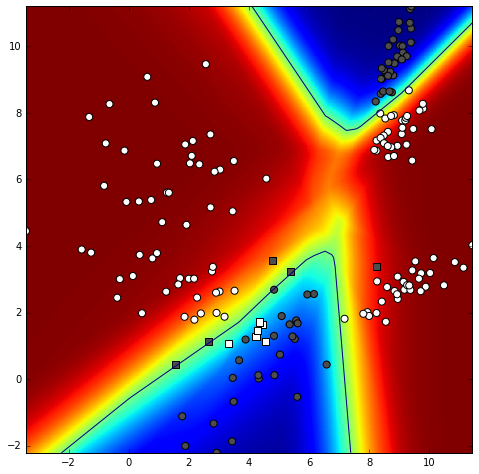

In [34]:
C=2
np.random.seed(423245)
layers = [2,10,10,2]
input_data, expected_output = sample_gmm_2d(6,C,30)

tfDeep = TFDeep(layer=layers,param_delta=0.01,param_lambda=0.01,activation=tf.nn.relu,std=0.1, batch_norm=True)
tfDeep.train(input_data,labels_to_one_hot(expected_output,C),10000,print_every=50,early_stop_after=50,minibatch=20)

def predict_c1_class_tf(X):
    def classify(X):
        return tfDeep.eval(X)[:,1]
    return classify


decfun = predict_c1_class_tf(input_data)

# evaluate the model on the train set
probs = tfDeep.eval(input_data)

# recover the predicted classes Y
my_predictions = probs[:,1] >0.5
my_predictions = my_predictions.flatten()


# graph the decision surface
bbox=(np.min(input_data, axis=0), np.max(input_data, axis=0))

#axis limits of the graph
xmin, ymin = bbox[0]
xmax, ymax = bbox[1]
plt.figure(figsize=(8,8))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

possible_labels = np.array(range(C))
mat = get_confusion_matrix(my_predictions,expected_output,possible_labels,True)
accuracy, prec, rec = eval_perf_multi(mat)
AP_c0 = eval_AP(expected_output[probs[:,0].argsort()],0)
AP_c1 = eval_AP(expected_output[probs[:,1].argsort()],1)

print "accuracy"
print accuracy
print "precision"
print prec
print "recall"
print rec
print "AP_c0"
print AP_c0
print "AP_c1"
print AP_c1

graph_surface(decfun, bbox, offset=0.5)

# graph the data points
graph_data(input_data, expected_output, my_predictions)

# show the plot
plt.show()

In [40]:

# # graph the decision surface
# bbox=(np.min(input_data, axis=0), np.max(input_data, axis=0))

# #axis limits of the graph
# xmin, ymin = bbox[0]
# xmax, ymax = bbox[1]
# plt.figure(figsize=(8,8))
# plt.xlim([xmin,xmax])
# plt.ylim([ymin,ymax])

# possible_labels = np.array(range(C))
# mat = get_confusion_matrix(my_predictions,expected_output,possible_labels,True)
# accuracy, prec, rec = eval_perf_multi(mat)
# AP_c0 = eval_AP(expected_output[probs[:,0].argsort()],0)
# AP_c1 = eval_AP(expected_output[probs[:,1].argsort()],1)

# print "accuracy"
# print accuracy
# print "precision"
# print prec
# print "recall"
# print rec
# print "AP_c0"
# print AP_c0
# print "AP_c1"
# print AP_c1

# graph_surface(decfun, bbox, offset=0.5)

# # graph the data points
# graph_data(input_data, expected_output, my_predictions)

# # show the plot